In [1]:
%matplotlib inline

from sklearn.datasets import load_files
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import tensorflow_datasets as tfds

sns.set_style('whitegrid')

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')


results_path = Path('results', 'transfer_learning')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [3]:
tfds.list_builders() # Load TensorFlow Cats vs Dog Dataset

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc',
 'bair_robot_pushing_small',
 'bccd',
 'beans',
 'big_patent',
 'bigearthnet',
 'billsum',
 'binarized_mnist',
 'binary_alpha_digits',
 'blimp',
 'bool_q',
 'c4',
 'caltech101',
 'caltech_birds2010',
 'caltech_birds2011',
 'cars196',
 'cassava',
 'cats_vs_dogs',
 'celeb_a',
 'celeb_a_hq',
 'cfq',
 'cherry_blossoms',
 'chexpert',
 'cifar10',
 'cifar100',
 'cifar10_1',
 'cifar10_corrupted',
 'citrus_leaves',
 'cityscapes',
 'civil_comments',
 'clevr',
 'clic',
 'clinc_oos',
 'cmaterdb',
 'cnn_dailymail',
 'coco',
 'coco_captions',
 'coil100',
 'colorectal_histology',
 'colorectal_histology_large',
 'common_voice',
 'coqa',
 'cos_e',
 'cosmos_qa',
 'covid19sum',
 'crema_d',
 'curated_breast_imaging_ddsm',
 'cycle_gan',
 'd4rl_mujoco_ant',
 'd4rl_mujoco_halfcheetah',
 'dart',
 'davis',
 'deep_weeds',
 'definite_pronoun_resolution',
 'dementiab

In [4]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
     split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, as_supervised=True, data_dir='data/tensorflow')
print('Raw train:\t', raw_train)
print('Raw validation:\t', raw_validation)
print('Raw test:\t', raw_test)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling cats_vs_dogs-train.tfrecord...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to data/tensorflow\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.
Raw train:	 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Raw validation:	 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
Raw test:	 <PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


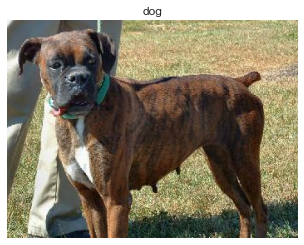

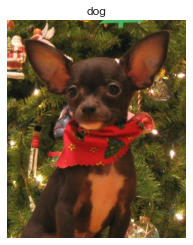

In [5]:
# Show sample images
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))
    plt.grid(False)
    plt.axis('off')

In [6]:
# Preprocessing
IMG_SIZE = 160
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [7]:
# Load the VGG-16 Bottleneck Features
vgg16 = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [8]:
feature_batch = vgg16(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [9]:
# Freeze model layers
vgg16.trainable = False
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [10]:
# Add new layers to model
global_average_layer = GlobalAveragePooling2D()
dense_layer = Dense(64, activation='relu')
dropout = Dropout(0.5)
prediction_layer = Dense(1, activation='sigmoid')
seq_model = tf.keras.Sequential([vgg16, global_average_layer, dense_layer, dropout, prediction_layer])
seq_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = 'Adam',
                       metrics=["accuracy"])
seq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                32832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,747,585
Trainable params: 32,897
Non-trainable params: 14,714,688
_______________________________________

In [11]:
# Using the Functional model API
#Adding custom Layers
x = vgg16.output
x = GlobalAveragePooling2D()(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

transfer_model = Model(inputs = vgg16.input, outputs = predictions)
transfer_model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer = 'Adam',
                       metrics=["accuracy"])
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [12]:
# Compute baseline metrics
initial_epochs = 10
validation_steps=20

initial_loss, initial_accuracy = transfer_model.evaluate(validation_batches, steps = validation_steps)
print(f'Initial loss: {initial_loss:.2f} | initial_accuracy accuracy: {initial_accuracy:.2%}')

D:\99.Dev\Python\pythonProject\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


20/20 [==============================] - 5s 89ms/step - loss: 0.9425 - accuracy: 0.4703
Initial loss: 0.94 | initial_accuracy accuracy: 47.03%


In [13]:
# Train VGG16 transfer model
history = transfer_model.fit(train_batches, epochs=initial_epochs, validation_data=validation_batches
                             , workers=6)

Epoch 1/10
582/582 [==============================] - 70s 117ms/step - loss: 0.2444 - accuracy: 0.8975 - val_loss: 0.1621 - val_accuracy: 0.9338
Epoch 2/10
582/582 [==============================] - 66s 112ms/step - loss: 0.1664 - accuracy: 0.9320 - val_loss: 0.1450 - val_accuracy: 0.9351
Epoch 3/10
582/582 [==============================] - 66s 113ms/step - loss: 0.1557 - accuracy: 0.9367 - val_loss: 0.1411 - val_accuracy: 0.9398
Epoch 4/10
582/582 [==============================] - 67s 114ms/step - loss: 0.1451 - accuracy: 0.9423 - val_loss: 0.1426 - val_accuracy: 0.9368
Epoch 5/10
582/582 [==============================] - 67s 114ms/step - loss: 0.1404 - accuracy: 0.9428 - val_loss: 0.1369 - val_accuracy: 0.9437
Epoch 6/10
582/582 [==============================] - 68s 115ms/step - loss: 0.1358 - accuracy: 0.9444 - val_loss: 0.1343 - val_accuracy: 0.9463
Epoch 7/10
582/582 [==============================] - 69s 117ms/step - loss: 0.1322 - accuracy: 0.9465 - val_loss: 0.1341 - val_ac

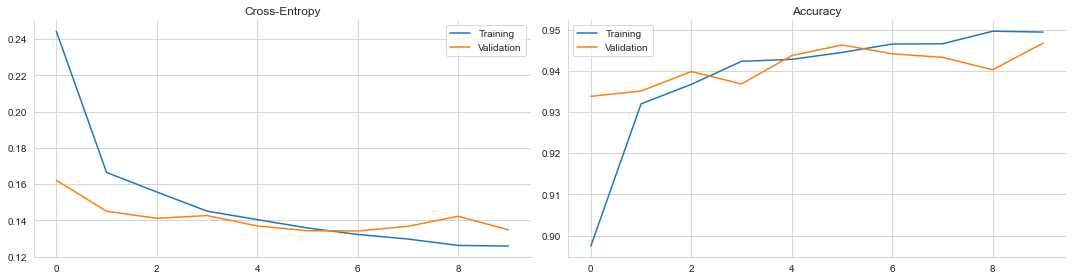

In [14]:
# Plot Learning Curves
def plot_learning_curves(df):
    fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
    df[['loss', 'val_loss']].plot(ax=axes[0], title='Cross-Entropy')
    df[['accuracy', 'val_accuracy']].plot(ax=axes[1], title='Accuracy')
    for ax in axes:
        ax.legend(['Training', 'Validation'])
    sns.despine()
    fig.tight_layout();

metrics = pd.DataFrame(history.history)
plot_learning_curves(metrics)

In [15]:
# Fine-tune VGG16 weights

vgg16.trainable = True # Unfreeze selected layers
print(f'Number of layers in the base model: {len(vgg16.layers)}')

Number of layers in the base model: 19


In [16]:
# Fine-tune from this layer onwards
start_fine_tuning_at = 12

# Freeze all the layers before the `fine_tune_at` layer
for layer in vgg16.layers[:start_fine_tuning_at]:
    layer.trainable =  False

base_learning_rate = 0.0001
transfer_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate / 10), metrics=['accuracy'])

D:\99.Dev\Python\pythonProject\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
# Define callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)
transfer_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [18]:
# Continue Training
fine_tune_epochs = 50
total_epochs = initial_epochs + fine_tune_epochs

history_fine_tune = transfer_model.fit(train_batches, epochs=total_epochs, initial_epoch=history.epoch[-1],
                                       validation_data=validation_batches, callbacks=[early_stopping],
                                       workers=6)

Epoch 10/60


D:\99.Dev\Python\pythonProject\lib\site-packages\tensorflow\python\util\dispatch.py:1096: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


582/582 [==============================] - 93s 154ms/step - loss: 0.1096 - accuracy: 0.9589 - val_loss: 0.1176 - val_accuracy: 0.9587
Epoch 11/60
582/582 [==============================] - 92s 157ms/step - loss: 0.0513 - accuracy: 0.9816 - val_loss: 0.1092 - val_accuracy: 0.9673
Epoch 12/60
582/582 [==============================] - 93s 159ms/step - loss: 0.0250 - accuracy: 0.9914 - val_loss: 0.1256 - val_accuracy: 0.9682
Epoch 13/60
582/582 [==============================] - 96s 163ms/step - loss: 0.0133 - accuracy: 0.9954 - val_loss: 0.1970 - val_accuracy: 0.9639
Epoch 14/60
582/582 [==============================] - 94s 159ms/step - loss: 0.0076 - accuracy: 0.9976 - val_loss: 0.2505 - val_accuracy: 0.9600
Epoch 15/60
582/582 [==============================] - 92s 157ms/step - loss: 0.0059 - accuracy: 0.9982 - val_loss: 0.1771 - val_accuracy: 0.9729
Epoch 16/60
582/582 [==============================] - 92s 158ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.2851 - val_accurac

C:\Users\19498\AppData\Local\Temp\ipykernel_19180\4114211492.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)


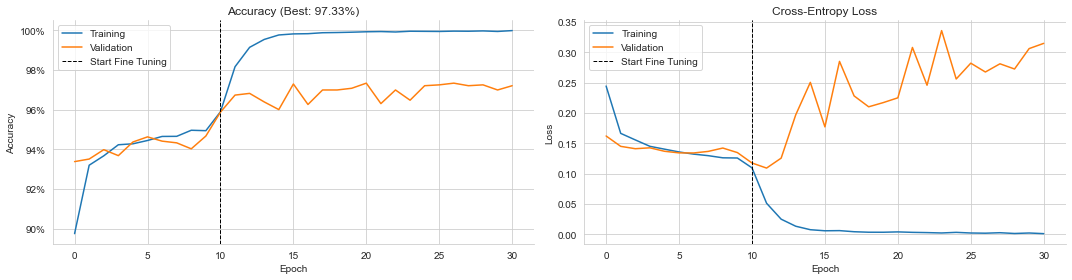

In [19]:
metrics_tuned = metrics.append(pd.DataFrame(history_fine_tune.history), ignore_index=True)
fig, axes = plt.subplots(ncols=2, figsize=(15, 4))
metrics_tuned[['loss', 'val_loss']].plot(ax=axes[1], title='Cross-Entropy Loss')
metrics_tuned[['accuracy', 'val_accuracy']].plot(ax=axes[0], title=f'Accuracy (Best: {metrics_tuned.val_accuracy.max():.2%})')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy')
axes[1].set_ylabel('Loss')

for ax in axes:
    ax.axvline(10, ls='--', lw=1, c='k')
    ax.legend(['Training', 'Validation', 'Start Fine Tuning'])
    ax.set_xlabel('Epoch')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'transfer_learning');